In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import pandas as pd
import torch.nn as nn

from utils.dataloader  import FaceDataset, preprocess, postprocess
from utils.learning import testing, training
from utils.utils_data import train_validation_test_split
from utils.visiualisation import display_graph_learning
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from models.resnet import ResnetCustomModel
from tqdm import tqdm

torch.cuda.empty_cache()

## Classification Resnet Custom

### Telechargement et Visualisation de notre jeu de donnée

In [12]:
faceDataset = FaceDataset(preprocess(), is_classification=True)
print(f'Taille du dataset: {len(faceDataset)}')

Taille du dataset: 43266


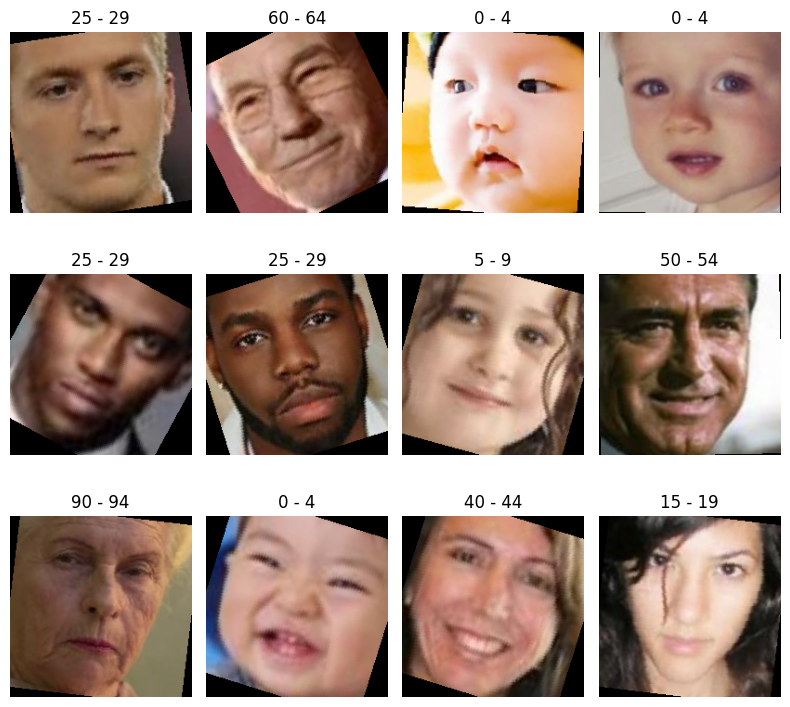

In [13]:
fig, ax = plt.subplots(3, 4, tight_layout=True, figsize=(8, 8))

label_names = faceDataset.get_all_age_range()

for i in range(3):
    for j in range(4):
        rand_idx = np.random.randint(0, len(faceDataset))
        img, label = faceDataset[rand_idx]
        postprocess_apply = postprocess()
        ax[i,j].imshow(postprocess_apply(img))
        ax[i,j].set_title(label_names[label])
        ax[i,j].set_axis_off()
        

##### Visualisation de la distribution des données

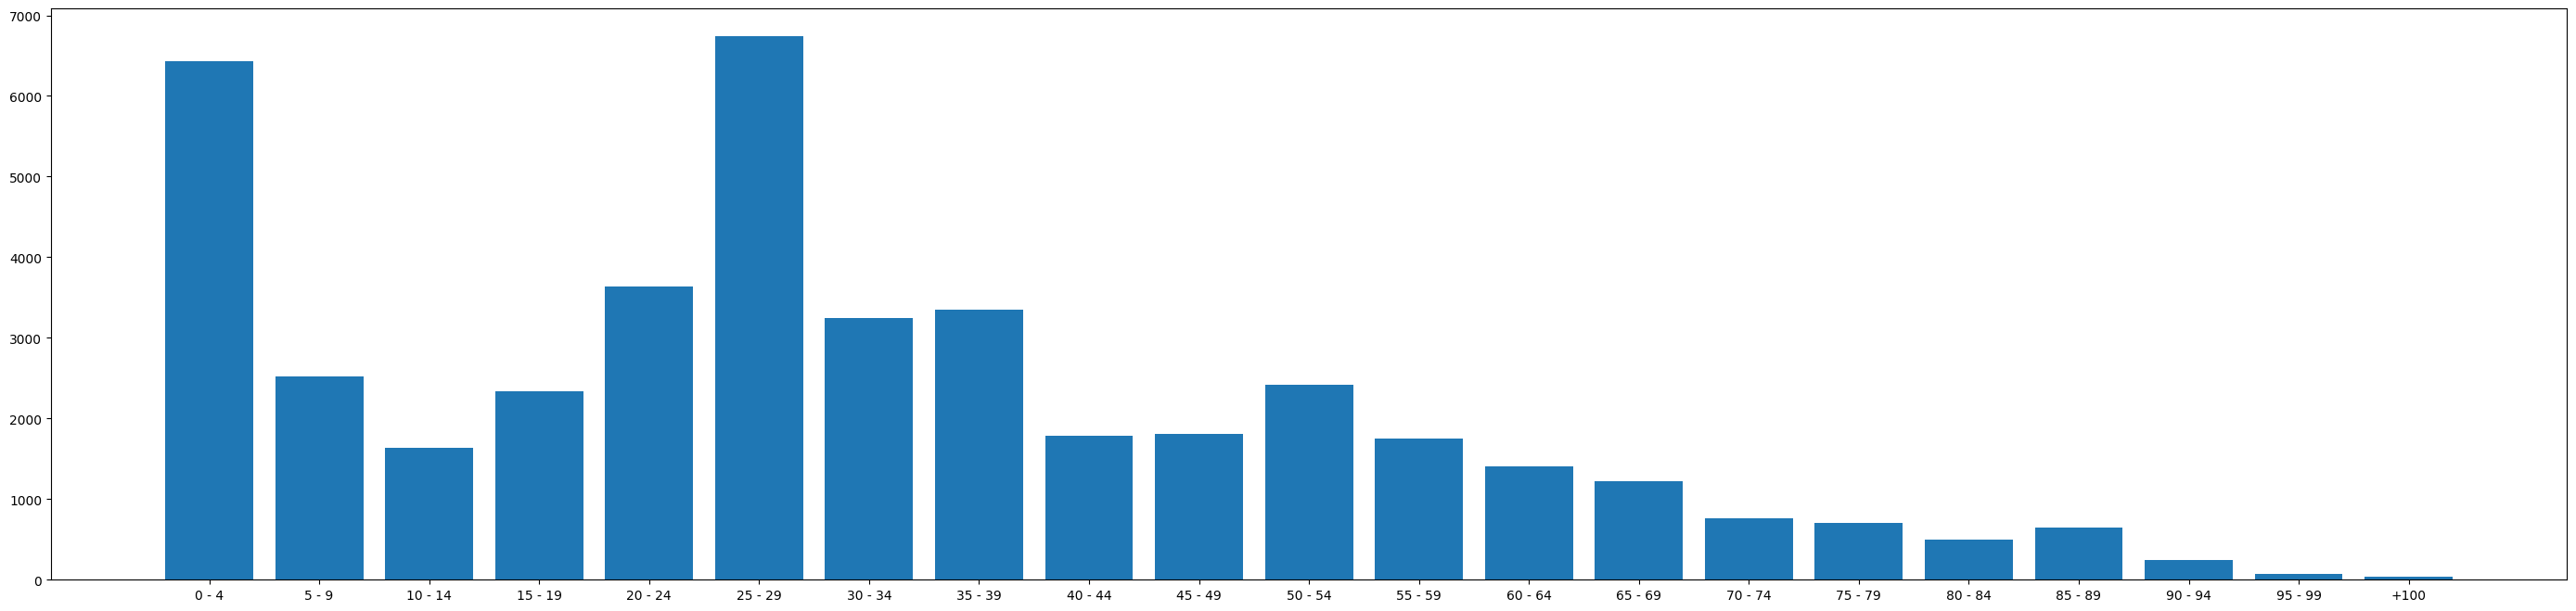

In [14]:
img_by_age_range = faceDataset.img_labels.groupby(['age_range'])['age_range']
df = img_by_age_range.count()

fig, ax = plt.subplots(figsize=(35, 8))
bar_container = ax.bar(label_names.values(), df.values)


## Regression Resnet Custom

In [15]:
faceDataset = FaceDataset(preprocess(), is_classification=False)

### Split dataset train, validation et test

In [16]:
train_sampler, validation_sampler, test_sampler = train_validation_test_split(faceDataset, validation_size=0.2, test_size=0.2)

### Entrainement

In [28]:
# make ce
batch_size=80
learning_rate=1e-4

criterion = nn.MSELoss()

 
model = ResnetCustomModel()

optimizer = Adam(params=model.parameters(), lr=learning_rate)


train_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=test_sampler)

model, hist_train_loss, hist_val_loss = training(model, 1, criterion=criterion, optimizer=optimizer, train_loader=validation_loader, validation_loader=validation_loader, patient=0,  DEVICE='cuda')

Training process epoch 1/1


100%|██████████| 87/87 [01:18<00:00,  1.11it/s]


Test process 1/1


100%|██████████| 87/87 [00:38<00:00,  2.28it/s]


 [-] epoch 1/1, train loss 657.933249, valiation loss 519.806078
 


Test: 100%|██████████| 109/109 [00:49<00:00,  2.21it/s]

 [-] Test loss 516.313435


### Test

In [30]:
# make test
images_correct, images_incorrect, y, y_true = test(model, criterion, test_validation=test_loader, DEVICE='cuda')

0


### Visualisation des données et discussion

In [ ]:
# visualisation
display_graph_learning(hist_train_loss, hist_val_loss, "Perte Pendant l'entrainement")

## Classification Resnet Custom

In [ ]:
faceDataset = FaceDataset(preprocess(), is_classification=True)

### Entrainement

In [ ]:
# make training

### Test

In [ ]:
# make test

### Visualisation des données et discussion

In [ ]:
# visualisation